In [1]:
import matplotlib.pyplot as plt
import numpy as np
import eispac
import astropy.units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from specutils.manipulation import SplineInterpolatedResampler
import h5py

In [2]:
data_filepath = '../../src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5'
qs_fexii_195_file = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_195_119.2c-0.fit.h5"

In [3]:
qs_fexii_195_fitres = eispac.read_fit(qs_fexii_195_file)
qs_fexii_195_intmap = qs_fexii_195_fitres.get_map(component=0, measurement='intensity')

Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_12_195_119.2c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [4]:
qs_shiftx, qs_shifty = 4.5*u.arcsec, -4*u.arcsec
qs_fexii_195_intmap_shifted = qs_fexii_195_intmap.shift(qs_shiftx, qs_shifty)
qs_fexii_195_intmap_shifted.bottom_left_coord

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2017-08-21T21:09:50.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T21:09:50.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (8.71063623e-15, 6.93331769, 1.51320798e+11)>): (Tx, Ty) in arcsec
    (-931.76660824, 312.38156128)>

In [5]:
top_left = qs_fexii_195_intmap_shifted.pixel_to_world(0*u.pix,159*u.pix)
np.sqrt(top_left.Tx**2 + top_left.Ty**2)/(950*u.arcsec)

<Quantity 1.099176>

In [6]:
bottom_left = qs_fexii_195_intmap_shifted.pixel_to_world(0*u.pix,20*u.pix)
np.sqrt(bottom_left.Tx**2 + bottom_left.Ty**2)/(950*u.arcsec)

<Quantity 1.0413429>

In [7]:
data_cube_0 = eispac.read_cube(data_filepath,0)
data_cube_1 = eispac.read_cube(data_filepath,1)
data_cube_2 = eispac.read_cube(data_filepath,2)
data_cube_3 = eispac.read_cube(data_filepath,3)

Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 1
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/EastOffLimbFullSpectra/eis_20170821_205401.head.h5
Found window 2
INFO: uncertainty should have attribute uncertainty_type. [astropy.ndda

In [8]:
data_cube_0.uncertainty.array.shape

(160, 60, 1024)

In [9]:
data_cube_0.uncertainty.unit

In [10]:
data_cube_0.wavelength.shape

(160, 60, 1024)

In [11]:
data_cube_0.meta["ccd_offset"]

array([18.482306, 18.480537, 18.47877 , ..., 16.678743, 16.67698 ,
       16.675213], dtype=float32)

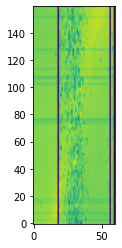

In [12]:
plt.imshow(np.nansum(data_cube_0.data[:,:,800:820],axis=2),origin="lower")

In [13]:
def interp_window_slit_tilt(data,err,wvl):
    data_shape = data.shape
    data_interp = np.zeros(data_shape)
    err_interp = np.zeros(data_shape)
    for ii in range(data_shape[0]):
        for jj in range(data_shape[1]):
            interp_spline = SplineInterpolatedResampler()
            spec_grid = data[ii,jj,:]
            bad_mask = np.ones(len(spec_grid), dtype=bool)
            bad_mask[np.where(spec_grid < -100)] = False
            spec_grid = spec_grid[bad_mask,]*u.adu
            wvl_grid = wvl[ii,jj,:]
            wvl_grid = wvl_grid[bad_mask,]*u.AA
            wvl_grid_interp = wvl[0,0,:]*u.AA
            err_grid = err.array[ii,jj,:]
            data_err = StdDevUncertainty(err_grid[bad_mask,])
            input_spec = Spectrum1D(flux=spec_grid,spectral_axis=wvl_grid,uncertainty=data_err)
            interp_spec = interp_spline(input_spec,wvl_grid_interp)

            data_interp[ii,jj,:] = interp_spec.flux.value
            err_interp[ii,jj,:] = interp_spec.uncertainty.array
    
    return data_interp, err_interp

In [14]:
data_cube_0_interp, err_cube_0_interp = interp_window_slit_tilt(data_cube_0.data[:,:16,:],data_cube_0.uncertainty[:,:16,:],data_cube_0.wavelength[:,:16,:])

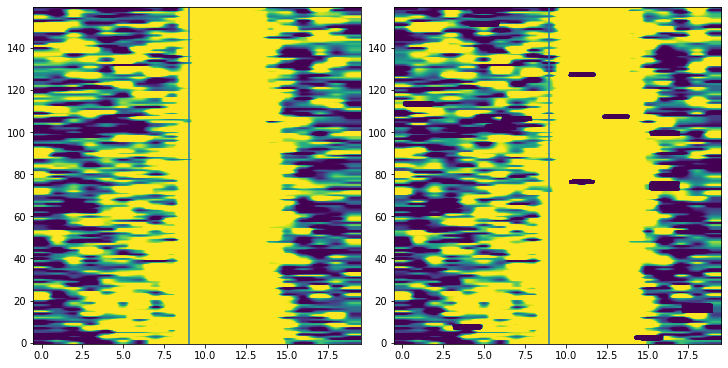

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)
ax1.imshow(data_cube_0_interp[:,0,800:820],aspect="auto",origin="lower",vmin=0,vmax=100)
ax2.imshow(data_cube_0.data[:,0,800:820],aspect="auto",origin="lower",vmin=0,vmax=100)
for ax_ in (ax1,ax2):
    ax_.axvline(9)

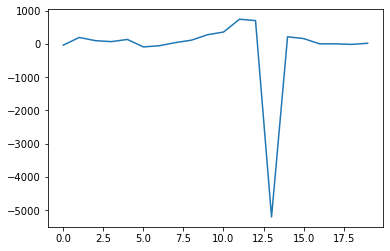

In [16]:
plt.plot(data_cube_0.data[108,0,800:820])

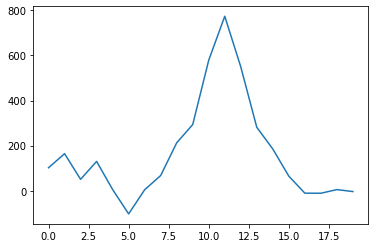

In [17]:
plt.plot(data_cube_0_interp[108,0,800:820])

In [18]:
data_cube_1_interp, err_cube_1_interp = interp_window_slit_tilt(data_cube_1.data[:,:16,:],data_cube_1.uncertainty[:,:16,:],data_cube_1.wavelength[:,:16,:])

In [19]:
data_cube_2_interp, err_cube_2_interp = interp_window_slit_tilt(data_cube_2.data[:,:16,:],data_cube_2.uncertainty[:,:16,:],data_cube_2.wavelength[:,:16,:])

In [20]:
data_cube_3_interp, err_cube_3_interp = interp_window_slit_tilt(data_cube_3.data[:,:16,:],data_cube_3.uncertainty[:,:16,:],data_cube_3.wavelength[:,:16,:])

In [21]:
with h5py.File("../../sav/EIS/EQSPY/Atlas30_tiltcorr_crop.h5", 'w') as hf:
    df_data_cube_0 = hf.create_dataset("data_cube_0",  data=data_cube_0_interp)
    df_err_cube_0 = hf.create_dataset("err_cube_0",  data=err_cube_0_interp)
    df_wvl_cube_0 = hf.create_dataset("wvl_cube_0",  data=data_cube_0.wavelength[0,0,:])
    df_data_cube_1 = hf.create_dataset("data_cube_1",  data=data_cube_1_interp)
    df_err_cube_1 = hf.create_dataset("err_cube_1",  data=err_cube_1_interp)
    df_wvl_cube_1 = hf.create_dataset("wvl_cube_1",  data=data_cube_1.wavelength[0,0,:])
    df_data_cube_2 = hf.create_dataset("data_cube_2",  data=data_cube_2_interp)
    df_err_cube_2 = hf.create_dataset("err_cube_2",  data=err_cube_2_interp)
    df_wvl_cube_2 = hf.create_dataset("wvl_cube_2",  data=data_cube_2.wavelength[0,0,:])
    df_data_cube_3 = hf.create_dataset("data_cube_3",  data=data_cube_3_interp)
    df_err_cube_3 = hf.create_dataset("err_cube_3",  data=err_cube_3_interp)
    df_wvl_cube_3 = hf.create_dataset("wvl_cube_3",  data=data_cube_3.wavelength[0,0,:])
    df_ccd_offset_0 = hf.create_dataset("ccd_offset_0",  data=data_cube_0.meta["ccd_offset"])
    df_ccd_offset_1 = hf.create_dataset("ccd_offset_1",  data=data_cube_1.meta["ccd_offset"])
    df_ccd_offset_2 = hf.create_dataset("ccd_offset_2",  data=data_cube_2.meta["ccd_offset"])
    df_ccd_offset_3 = hf.create_dataset("ccd_offset_3",  data=data_cube_3.meta["ccd_offset"])
    df_fexii_bottom_left = hf.create_dataset("fexii_195_bottom_left", data=np.array([qs_fexii_195_intmap_shifted.bottom_left_coord.Tx.value,
                                                                                     qs_fexii_195_intmap_shifted.bottom_left_coord.Ty.value]))
    df_slit_width = hf.create_dataset("slit_width", data=data_cube_0.meta["slit_width"])